# Coronavirus Prediction

## Overview

This project predicts related rates with deep learning methods.

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import json
import time
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pickle

#import geopandas as gpd

In [2]:
%%capture
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
tqdm().pandas()

# Data Collection

## Coronavirus API

https://www.programmableweb.com/api/coronavirus-tracker-rest-api-v20

In [3]:
url = 'https://coronavirus-tracker-api.herokuapp.com/v2/locations'

random = np.random.uniform(0, 1, 501)
# time.sleep(random[i])
params = {  
            #'source': 'csbs',
            #'country_code': 'US',           
            'timelines': 1
          }

response = requests.get(url, params)
d = response.json()

In [5]:
ts = pd.DataFrame(d['locations'][248]['timelines']['deaths'])

In [6]:
ts.index = pd.to_datetime(ts.index).date

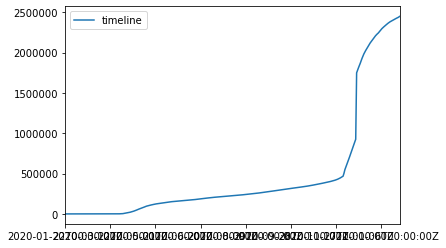

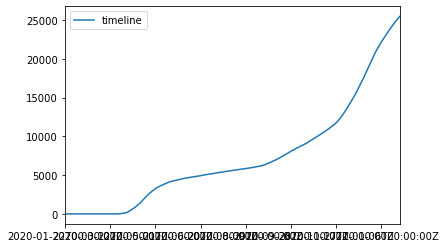

In [8]:
pd.DataFrame(d['locations'][248]['timelines']['confirmed']).plot()
pd.DataFrame(d['locations'][248]['timelines']['deaths']).plot()

In [9]:
df = pd.DataFrame(d['locations'])

In [10]:
df

,id,country,country_code,country_population,province,last_updated,coordinates,latest,timelines
0,0,Afghanistan,AF,37172386.0,,2021-01-28T23:34:21.197653Z,"{'latitude': '33.93911', 'longitude': '67.7099...","{'confirmed': 54854, 'deaths': 2389, 'recovere...",{'confirmed': {'timeline': {'2020-01-22T00:00:...
1,1,Albania,AL,2866376.0,,2021-01-28T23:34:21.226235Z,"{'latitude': '41.1533', 'longitude': '20.1683'}","{'confirmed': 74567, 'deaths': 1339, 'recovere...",{'confirmed': {'timeline': {'2020-01-22T00:00:...
2,2,Algeria,DZ,42228429.0,,2021-01-28T23:34:21.254827Z,"{'latitude': '28.0339', 'longitude': '1.6596'}","{'confirmed': 106359, 'deaths': 2877, 'recover...",{'confirmed': {'timeline': {'2020-01-22T00:00:...
3,3,Andorra,AD,77006.0,,2021-01-28T23:34:21.283231Z,"{'latitude': '42.5063', 'longitude': '1.5218'}","{'confirmed': 9716, 'deaths': 98, 'recovered':...",{'confirmed': {'timeline': {'2020-01-22T00:00:...
4,4,Angola,AO,30809762.0,,2021-01-28T23:34:21.311337Z,"{'latitude': '-11.2027', 'longitude': '17.8739'}","{'confirmed': 19580, 'deaths': 462, 'recovered...",{'confirmed': {'timeline': {'2020-01-22T00:00:...
...,...,...,...,...,...,...,...,...,...
268,268,Vietnam,VN,95540395.0,,2021-01-28T23:34:26.801575Z,"{'latitude': '14.058324', 'longitude': '108.27...","{'confirmed': 1553, 'deaths': 35, 'recovered': 0}",{'confirmed': {'timeline': {'2020-01-22T00:00:...
269,269,West Bank and Gaza,PS,4569087.0,,2021-01-28T23:34:26.825694Z,"{'latitude': '31.9522', 'longitude': '35.2332'}","{'confirmed': 156996, 'deaths': 1808, 'recover...",{'confirmed': {'timeline': {'2020-01-22T00:00:...
270,270,Yemen,YE,28498687.0,,2021-01-28T23:34:26.846031Z,"{'latitude': '15.552727', 'longitude': '48.516...","{'confirmed': 2120, 'deaths': 615, 'recovered'...",{'confirmed': {'timeline': {'2020-01-22T00:00:...
271,271,Zambia,ZM,17351822.0,,2021-01-28T23:34:26.868628Z,"{'latitude': '-13.133897', 'longitude': '27.84...","{'confirmed': 48911, 'deaths': 688, 'recovered...",{'confirmed': {'timeline': {'2020-01-22T00:00:...


## API

https://covidtracking.com/data/api

In [11]:
url = 'https://api.covidtracking.com/v1/us/daily.json'

response = requests.get(url)
d = response.json()

In [12]:
pd.DataFrame(d)

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,lastModified,recovered,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,hash
0,20210127,56,25230559.0,114254529.0,11972.0,107444.0,795299.0,20497.0,41402.0,6806.0,...,2021-01-27T24:00:00Z,None,0,0,4077,4134,518507,151675,1627862,268d5f9be13dd337decb4e64028d02da2a1ea4c5
1,20210126,56,25078884.0,113736022.0,9879.0,108960.0,791165.0,20573.0,41205.0,6832.0,...,2021-01-26T24:00:00Z,None,0,0,3734,3705,565751,143745,1694608,e87dbfe98c638728e688c6661e930474f9824323
2,20210125,56,24935139.0,113170271.0,10963.0,109936.0,787460.0,20875.0,41028.0,6857.0,...,2021-01-25T24:00:00Z,None,0,0,1593,2515,535497,133067,1696188,74156b29125f67f674823acca634e0853809ca82
3,20210124,56,24802072.0,112634774.0,10892.0,110628.0,784945.0,21168.0,40931.0,6989.0,...,2021-01-24T24:00:00Z,None,0,0,1944,1909,412763,143691,1729017,c7b803e43d6761488ab5b5e7028bc601b951a63e
4,20210123,56,24658381.0,112222011.0,10864.0,113609.0,783036.0,21657.0,40853.0,7110.0,...,2021-01-23T24:00:00Z,None,0,0,3591,6652,559167,174705,1925169,5227975baffbfa78446b5dae425bb8c2de9df3e1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,20200117,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2020-01-17T24:00:00Z,None,0,0,0,0,0,0,0,5fd7ed7fb0f83565ea0aaaf5ff6104e5860be2d6
377,20200116,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2020-01-16T24:00:00Z,None,0,0,0,0,0,0,0,4c0f2ea879eefec1a18a93bcd8a382ea56cd452d
378,20200115,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2020-01-15T24:00:00Z,None,0,0,0,0,0,0,0,8a449023413eea473277416e9e30ae126c6af047
379,20200114,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2020-01-14T24:00:00Z,None,0,0,0,0,0,0,0,fe399466a3dfbe0221a18ed5cacb39a3882d72f8


In [13]:
url = 'https://api.covidtracking.com/v1/us/current.json'

response = requests.get(url)
d = response.json()

In [14]:
d

[{'date': 20210127,
  'states': 56,
  'positive': 25230559,
  'negative': 114254529,
  'pending': 11972,
  'hospitalizedCurrently': 107444,
  'hospitalizedCumulative': 795299,
  'inIcuCurrently': 20497,
  'inIcuCumulative': 41402,
  'onVentilatorCurrently': 6806,
  'onVentilatorCumulative': 3985,
  'dateChecked': '2021-01-27T24:00:00Z',
  'death': 419634,
  'hospitalized': 795299,
  'totalTestResults': 300080362,
  'lastModified': '2021-01-27T24:00:00Z',
  'recovered': None,
  'total': 0,
  'posNeg': 0,
  'deathIncrease': 4077,
  'hospitalizedIncrease': 4134,
  'negativeIncrease': 518507,
  'positiveIncrease': 151675,
  'totalTestResultsIncrease': 1627862,
  'hash': '268d5f9be13dd337decb4e64028d02da2a1ea4c5'}]

In [15]:
#url = 'https://api.covidtracking.com/v1/us/20200501.json'
url = 'https://api.covidtracking.com/v1/states/daily.json'

response = requests.get(url)
d = response.json()

In [16]:
pd.DataFrame(d)

,date,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,20210127,AK,51951.0,NaN,NaN,NaN,totalTestsViral,1467400.0,49.0,1200.0,...,51951,1,6,f860fa6612bfb8b32661335f13f2beafdac5ae55,0,0,0,0,0,
1,20210127,AL,449086.0,94119.0,1751068.0,NaN,totalTestsPeopleViral,2106035.0,2122.0,41483.0,...,2200154,276,168,ea8318ddf483ea583e591140d24dbb43210ec36f,0,0,0,0,0,
2,20210127,AR,288964.0,58097.0,2149071.0,NaN,totalTestsViral,2379938.0,1029.0,13447.0,...,2438035,52,46,fc436a063fa7942d79458331987059714ae58d15,0,0,0,0,0,
3,20210127,AS,0.0,NaN,2140.0,NaN,totalTestsViral,2140.0,NaN,NaN,...,2140,0,0,33161a6289bcb7efb40e086dc073baec0d709aa9,0,0,0,0,0,
4,20210127,AZ,738561.0,46062.0,2702143.0,NaN,totalTestsViral,6504407.0,4250.0,51037.0,...,3440704,195,380,c32027cb5617b7520fafdc4979f464f4e464be2f,0,0,0,0,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18581,20200117,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,...,0,0,0,effcc7b17054638471dec2f2a9cdbd3229d92042,0,0,0,0,0,
18582,20200116,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,...,0,0,0,d9453d58f00994cff1f81639e95e532d1dd10138,0,0,0,0,0,
18583,20200115,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,...,0,0,0,bd1eef4afdffd883e37be1d3f321dc3b0e75f591,0,0,0,0,0,
18584,20200114,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,...,0,0,0,84aeea9c6a284b151fdb42a863db3c0aadb651bf,0,0,0,0,0,


In [17]:
# df = pd.read_excel('default of credit card clients.xls',  index_col=0, header=1)

In [18]:
df.columns

Index(['id', 'country', 'country_code', 'country_population', 'province',
       'last_updated', 'coordinates', 'latest', 'timelines'],
      dtype='object')

In [19]:
df

,id,country,country_code,country_population,province,last_updated,coordinates,latest,timelines
0,0,Afghanistan,AF,37172386.0,,2021-01-28T23:34:21.197653Z,"{'latitude': '33.93911', 'longitude': '67.7099...","{'confirmed': 54854, 'deaths': 2389, 'recovere...",{'confirmed': {'timeline': {'2020-01-22T00:00:...
1,1,Albania,AL,2866376.0,,2021-01-28T23:34:21.226235Z,"{'latitude': '41.1533', 'longitude': '20.1683'}","{'confirmed': 74567, 'deaths': 1339, 'recovere...",{'confirmed': {'timeline': {'2020-01-22T00:00:...
2,2,Algeria,DZ,42228429.0,,2021-01-28T23:34:21.254827Z,"{'latitude': '28.0339', 'longitude': '1.6596'}","{'confirmed': 106359, 'deaths': 2877, 'recover...",{'confirmed': {'timeline': {'2020-01-22T00:00:...
3,3,Andorra,AD,77006.0,,2021-01-28T23:34:21.283231Z,"{'latitude': '42.5063', 'longitude': '1.5218'}","{'confirmed': 9716, 'deaths': 98, 'recovered':...",{'confirmed': {'timeline': {'2020-01-22T00:00:...
4,4,Angola,AO,30809762.0,,2021-01-28T23:34:21.311337Z,"{'latitude': '-11.2027', 'longitude': '17.8739'}","{'confirmed': 19580, 'deaths': 462, 'recovered...",{'confirmed': {'timeline': {'2020-01-22T00:00:...
...,...,...,...,...,...,...,...,...,...
268,268,Vietnam,VN,95540395.0,,2021-01-28T23:34:26.801575Z,"{'latitude': '14.058324', 'longitude': '108.27...","{'confirmed': 1553, 'deaths': 35, 'recovered': 0}",{'confirmed': {'timeline': {'2020-01-22T00:00:...
269,269,West Bank and Gaza,PS,4569087.0,,2021-01-28T23:34:26.825694Z,"{'latitude': '31.9522', 'longitude': '35.2332'}","{'confirmed': 156996, 'deaths': 1808, 'recover...",{'confirmed': {'timeline': {'2020-01-22T00:00:...
270,270,Yemen,YE,28498687.0,,2021-01-28T23:34:26.846031Z,"{'latitude': '15.552727', 'longitude': '48.516...","{'confirmed': 2120, 'deaths': 615, 'recovered'...",{'confirmed': {'timeline': {'2020-01-22T00:00:...
271,271,Zambia,ZM,17351822.0,,2021-01-28T23:34:26.868628Z,"{'latitude': '-13.133897', 'longitude': '27.84...","{'confirmed': 48911, 'deaths': 688, 'recovered...",{'confirmed': {'timeline': {'2020-01-22T00:00:...


## API

https://cord19.vespa.ai

## Zip API

https://www.programmableweb.com/api/zip-api-us

In [20]:
from requests.auth import HTTPBasicAuth

In [21]:
# f = open('api.json')
# api_key = json.load(f)

In [22]:
# url = f"https://service.zipapi.us/hospital/radius/11367?X-API-KEY={api_key['zip_api']['api']}"

# params = {  
#             'radius': 20
#           }

# response = requests.get(url, params,  auth=HTTPBasicAuth(api_key['zip_api']['email'], api_key['zip_api']['password']))
# d = response.json()

In [23]:
# pd.DataFrame(d['data'])

In [24]:
# url = f"https://service.zipapi.us/age/zipcode/11367?X-API-KEY={api_key['zip_api']['api']}"

# # params = {  
# #             'fields': ['male_age','female_age']
# #           }

# response = requests.get(url, params,  auth=HTTPBasicAuth(api_key['zip_api']['email'], api_key['zip_api']['password']))
# d = response.json()

## Web Scraping

# Modeling

## SARIMAX

In [26]:
# import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# import utilities
import pickle
import requests
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

# display preferences
%matplotlib inline
register_matplotlib_converters()

In [27]:
def stationarity_check(TS):
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=7, center=False).mean()
    roll_std = TS.rolling(window=7, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

### EDA & Data Cleaning

In [28]:
url = 'https://api.covidtracking.com/v1/us/daily.json'
response = requests.get(url)
d = response.json()
df = pd.DataFrame(d)
df['date'] = pd.to_datetime(df.date, format='%Y%m%d')
df.set_index('date', inplace=True)
df = df[::-1] #<--- reverse chronology
# df.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq) #<--- set freq.

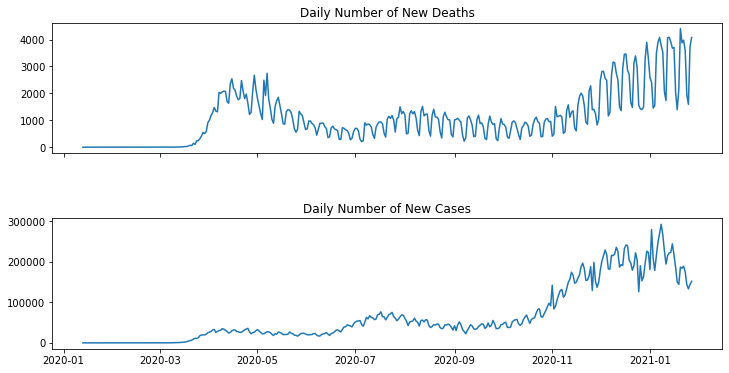

In [29]:
# construct seperate dataframes per target variable
deaths = pd.DataFrame(df.deathIncrease, index=df.index)
pos = pd.DataFrame(df.positiveIncrease, index=df.index)

# drop nan values from the start of each target dataframe
deaths.dropna(inplace=True)
pos.dropna(inplace=True)

# add one to all values of zero for log transforms
deaths['deathIncrease'] = np.where(deaths.deathIncrease == 0, 1, deaths.deathIncrease)
pos['positiveIncrease'] = np.where(pos.positiveIncrease == 0, 1, pos.positiveIncrease)

# plot target variables
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,6))
axs[0].plot(deaths)
axs[0].set_title('Daily Number of New Deaths')
axs[1].plot(pos)
axs[1].set_title('Daily Number of New Cases')
plt.subplots_adjust(hspace = 0.5)
plt.show()

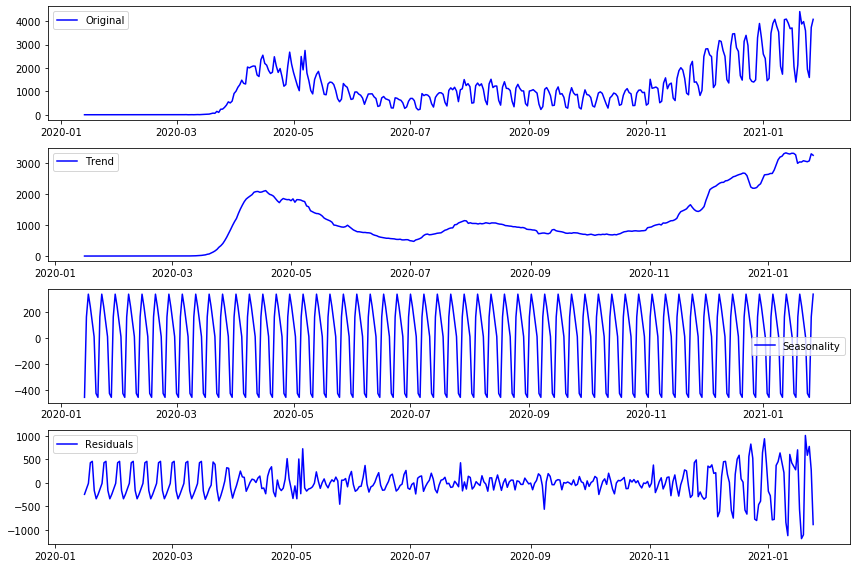

In [30]:
# Apply seasonal_decompose()
decomposition = seasonal_decompose(deaths)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(deaths, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

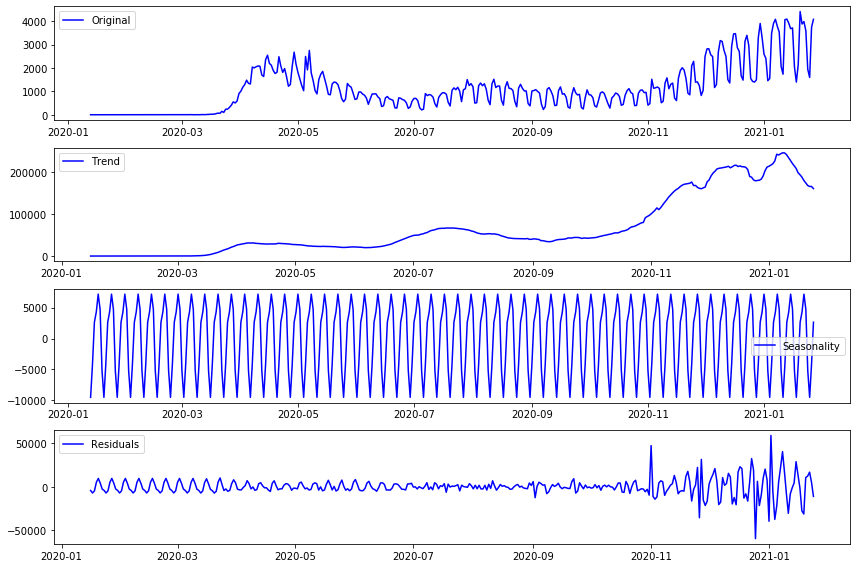

In [31]:
# Apply seasonal_decompose()
decomposition = seasonal_decompose(pos)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(deaths, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

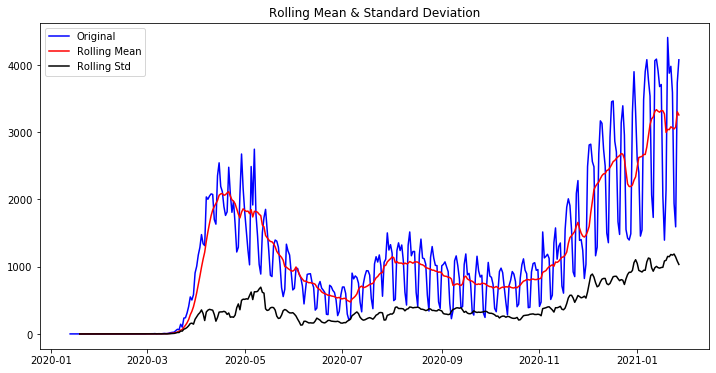

Results of Dickey-Fuller Test: 

Test Statistic                  -0.902184
p-value                          0.787252
#Lags Used                      14.000000
Number of Observations Used    366.000000
Critical Value (1%)             -3.448344
Critical Value (5%)             -2.869469
Critical Value (10%)            -2.570994
dtype: float64


In [32]:
stationarity_check(deaths)

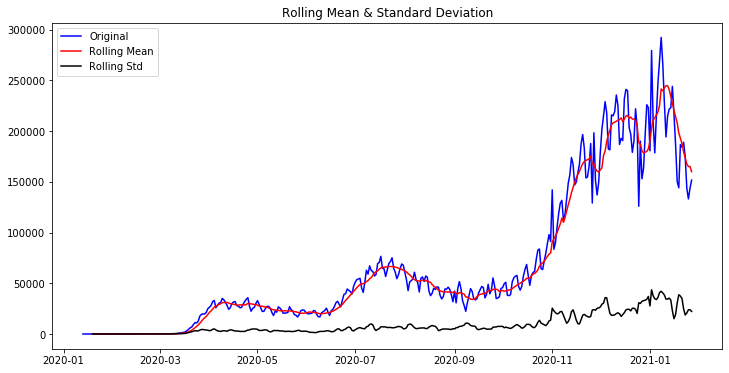

Results of Dickey-Fuller Test: 

Test Statistic                  -0.752723
p-value                          0.832616
#Lags Used                      15.000000
Number of Observations Used    365.000000
Critical Value (1%)             -3.448394
Critical Value (5%)             -2.869491
Critical Value (10%)            -2.571006
dtype: float64


In [33]:
stationarity_check(pos)

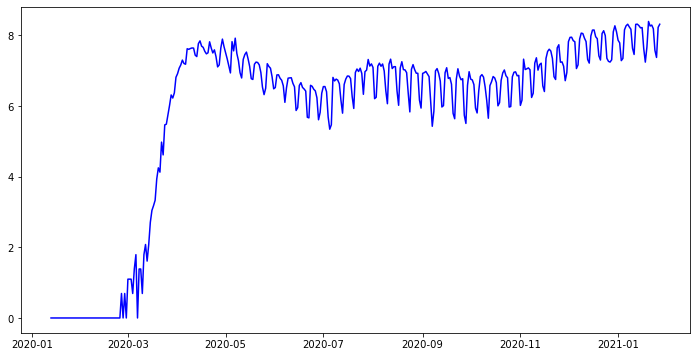

In [34]:
# Plot a log transform
deaths_log = np.log(deaths)
fig = plt.figure(figsize=(12,6))
plt.plot(deaths_log, color='blue');
plt.show()

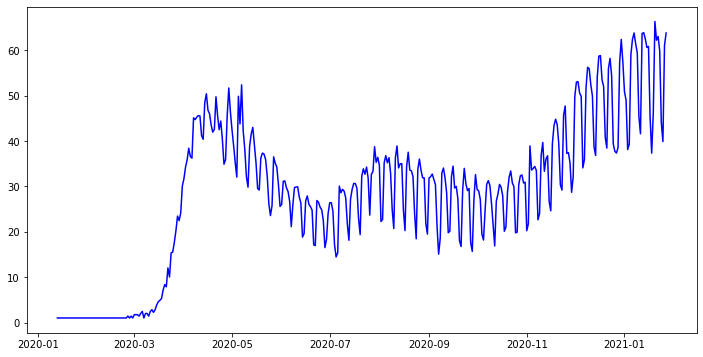

In [35]:
# Plot a square root transform
deaths_sqrt = np.sqrt(deaths)
fig = plt.figure(figsize=(12,6))
plt.plot(deaths_sqrt, color='blue');
plt.show()

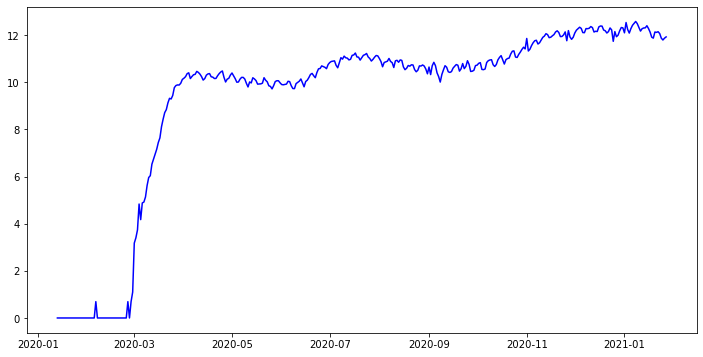

In [36]:
# Plot a log transform
pos_log = np.log(pos)
fig = plt.figure(figsize=(12,6))
plt.plot(pos_log, color='blue');
plt.show()

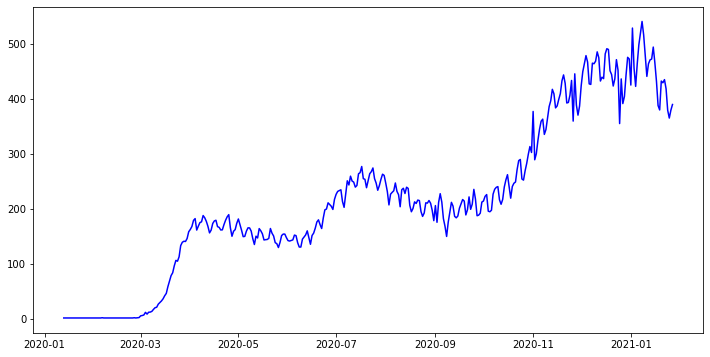

In [37]:
# Plot a square root transform
pos_sqrt = np.sqrt(pos)
fig = plt.figure(figsize=(12,6))
plt.plot(pos_sqrt, color='blue');
plt.show()

In [38]:
# Perform the Dickey Fuller test
print('deaths_log')
dftest = adfuller(deaths_log) 

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                         '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

# Perform the Dickey Fuller test
print('\ndeaths_sqrt')
dftest = adfuller(deaths_sqrt) 

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                         '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

# Perform the Dickey Fuller test
print('\npos_log')
dftest = adfuller(pos_log) 

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                         '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

# Perform the Dickey Fuller test
print('\npos_sqrt')
dftest = adfuller(pos_sqrt) 

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                         '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

deaths_log
Test Statistic                  -3.121710
p-value                          0.024988
#Lags Used                      16.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64

deaths_sqrt
Test Statistic                  -1.808162
p-value                          0.376417
#Lags Used                      14.000000
Number of Observations Used    366.000000
Critical Value (1%)             -3.448344
Critical Value (5%)             -2.869469
Critical Value (10%)            -2.570994
dtype: float64

pos_log
Test Statistic                  -2.815323
p-value                          0.056118
#Lags Used                       8.000000
Number of Observations Used    372.000000
Critical Value (1%)             -3.448052
Critical Value (5%)             -2.869341
Critical Value (10%)            -2.570926
dtype: float64

pos_sqrt
Test Statistic                

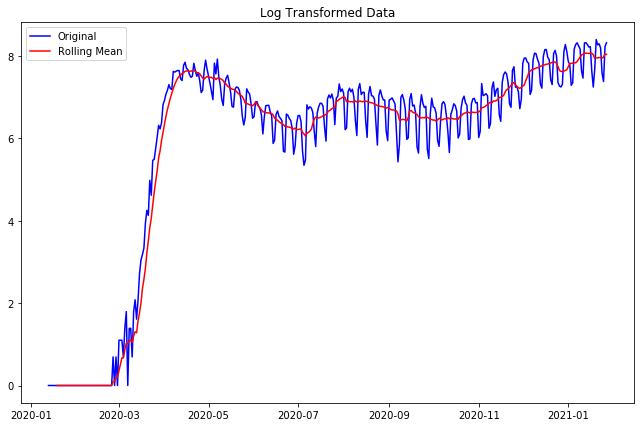

In [39]:
deaths_roll_mean = deaths_log.rolling(window=7).mean()
fig = plt.figure(figsize=(11,7))
plt.plot(deaths_log, color='blue', label='Original')
plt.plot(deaths_roll_mean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Log Transformed Data')
plt.show(block=False)

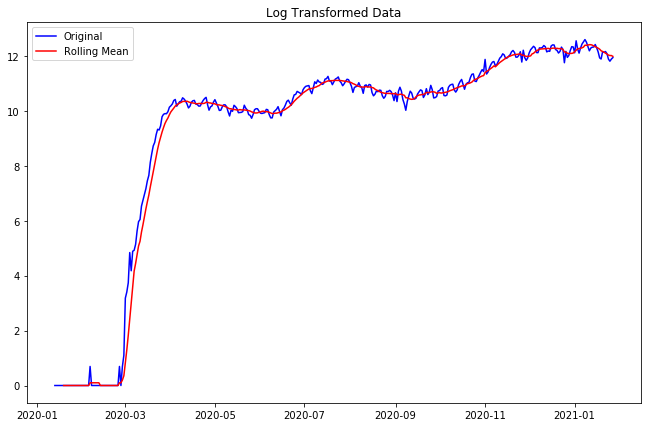

In [40]:
pos_roll_mean = pos_log.rolling(window=7).mean()
fig = plt.figure(figsize=(11,7))
plt.plot(pos_log, color='blue', label='Original')
plt.plot(pos_roll_mean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Log Transformed Data')
plt.show(block=False)

In [41]:
# Subtract the moving average from the log transformed data
deaths_data_minus_roll_mean = deaths_log - deaths_roll_mean
pos_data_minus_roll_mean = pos_log - pos_roll_mean

# Drop the missing values
deaths_data_minus_roll_mean.dropna(inplace=True)
pos_data_minus_roll_mean.dropna(inplace=True)

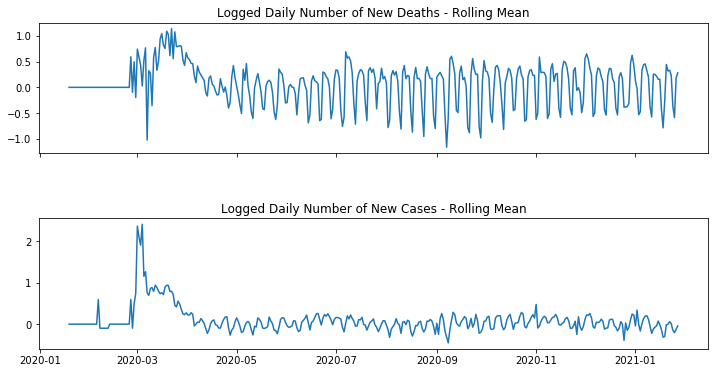

In [42]:
# replot target variables
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,6))
axs[0].plot(deaths_data_minus_roll_mean)
axs[0].set_title('Logged Daily Number of New Deaths - Rolling Mean')
axs[1].plot(pos_data_minus_roll_mean)
axs[1].set_title('Logged Daily Number of New Cases - Rolling Mean')
plt.subplots_adjust(hspace = 0.5)
plt.show()

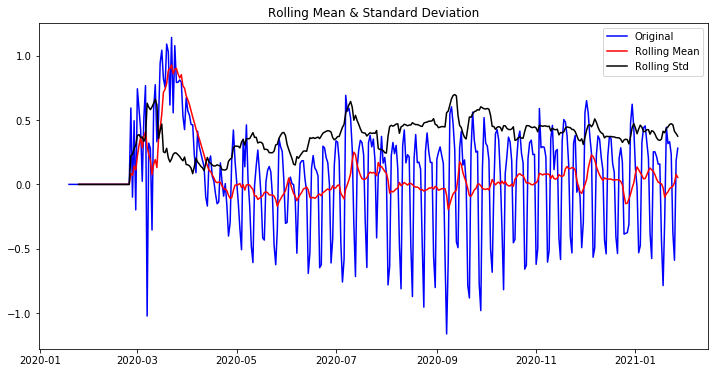

Results of Dickey-Fuller Test: 

Test Statistic                  -2.892933
p-value                          0.046176
#Lags Used                      16.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


In [43]:
stationarity_check(deaths_data_minus_roll_mean)

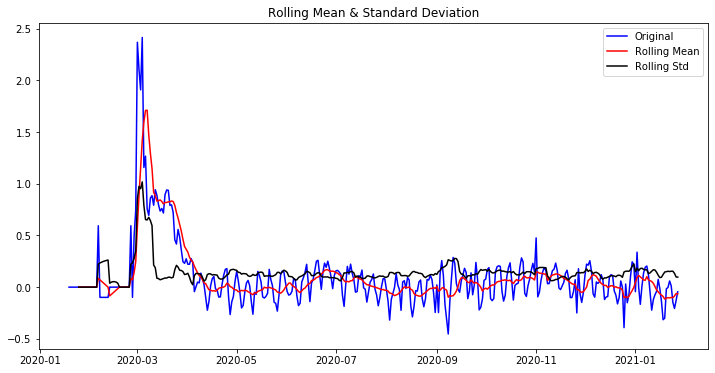

Results of Dickey-Fuller Test: 

Test Statistic                  -2.723401
p-value                          0.070076
#Lags Used                      13.000000
Number of Observations Used    361.000000
Critical Value (1%)             -3.448595
Critical Value (5%)             -2.869580
Critical Value (10%)            -2.571053
dtype: float64


In [44]:
stationarity_check(pos_data_minus_roll_mean)

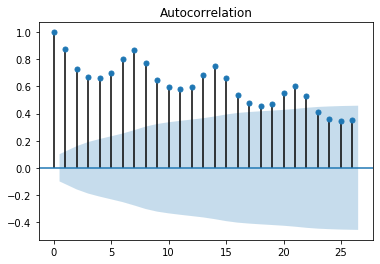

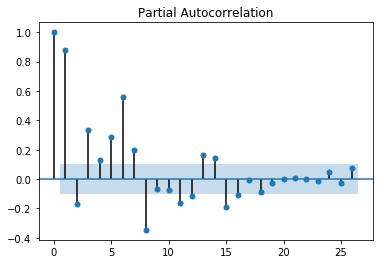

In [45]:
# Plot deaths ACF & PACF
plot_acf(deaths);
plot_pacf(deaths);
plt.show()

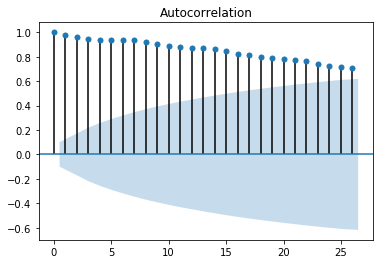

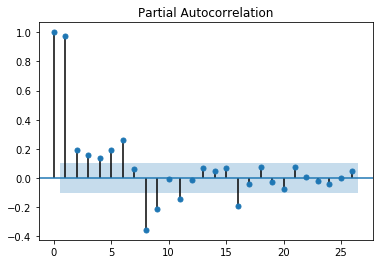

In [46]:
# Plot pos ACF & PACF
plot_acf(pos);
plot_pacf(pos);
plt.show()

### Modeling

In [47]:
# Define the p, d and q parameters to take any value between 0 and 2
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

#### Deaths Model

In [48]:
"""UNCOMMENT THIS CELL TO RUN GRID SEARCH"""
# # Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
# ans = []
# for comb in pdq:
#     for combs in pdqs:
#         try:
#             mod = SARIMAX(deaths_data_minus_roll_mean,
#                             order=comb,
#                             seasonal_order=combs,
#                             enforce_stationarity=False,
#                             enforce_invertibility=False)

#             output = mod.fit()
#             ans.append([comb, combs, output.aic])
#             print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
#         except:
#             continue

# # Find the parameters with minimal AIC value
# ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])

# # pickle grid parameters
# pickle_out = open("death_grid.pickle","wb")
# pickle.dump(ans_df, pickle_out)
# pickle_out.close()

'UNCOMMENT THIS CELL TO RUN GRID SEARCH'

In [49]:
# load grid parameters
ans_df = pd.read_pickle('death_grid.pickle')
ans_df

,pdq,pdqs,aic
0,"(0, 0, 0)","(0, 0, 0, 12)",397.102971
1,"(0, 0, 0)","(0, 0, 1, 12)",396.316500
2,"(0, 0, 0)","(0, 0, 2, 12)",376.550467
3,"(0, 0, 0)","(0, 1, 0, 12)",660.193705
4,"(0, 0, 0)","(0, 1, 1, 12)",418.654910
...,...,...,...
319,"(2, 1, 2)","(2, 0, 1, 12)",195.154712
320,"(2, 1, 2)","(2, 0, 2, 12)",152.793151
321,"(2, 1, 2)","(2, 1, 0, 12)",344.659830
322,"(2, 1, 2)","(2, 1, 1, 12)",222.797352


In [50]:
ARIMA_MODEL = SARIMAX(deaths_data_minus_roll_mean,
                      order=ans_df.loc[ans_df['aic'].idxmin()][0],
                      seasonal_order=ans_df.loc[ans_df['aic'].idxmin()][1],
                      enforce_stationarity=False,
                      enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2467      0.163     -1.511      0.131      -0.567       0.073
ar.L2         -0.2717      0.071     -3.828      0.000      -0.411      -0.133
ma.L1         -0.9462      0.219     -4.315      0.000      -1.376      -0.516
ma.L2         -0.4290      0.217     -1.978      0.048      -0.854      -0.004
ar.S.L12      -0.4120      0.032    -12.812      0.000      -0.475      -0.349
ar.S.L24      -0.9665      0.035    -27.248      0.000      -1.036      -0.897
ma.S.L12       0.2131      0.071      3.018      0.003       0.075       0.352
ma.S.L24       0.6588      0.067      9.858      0.000       0.528       0.790
sigma2         0.0506      0.007      7.461      0.000       0.037       0.064


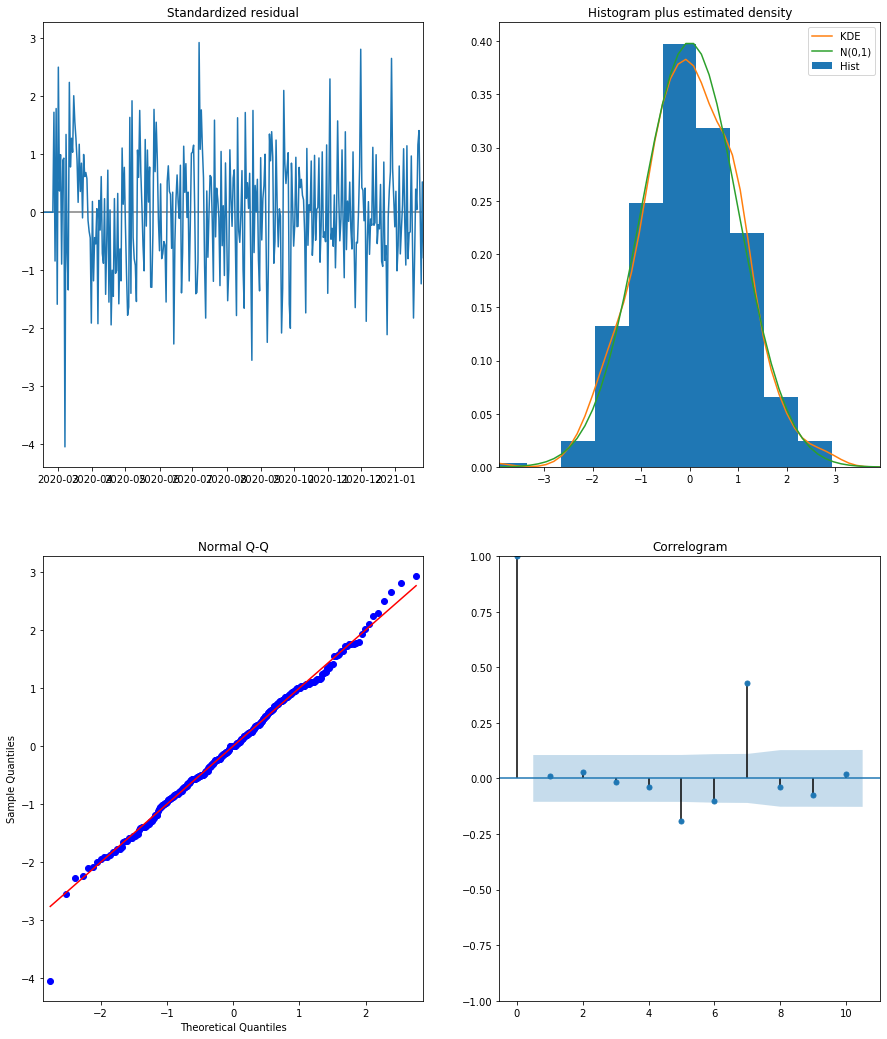

In [51]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [52]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2020-09-01'), dynamic=False)
pred_conf = pred.conf_int()

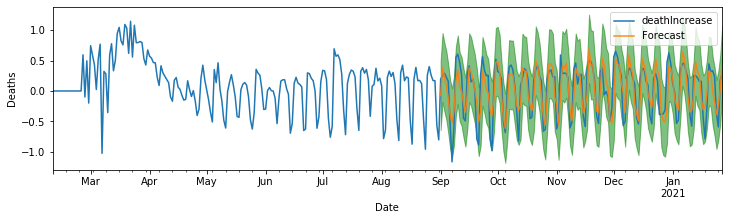

In [53]:
# Plot real vs predicted values along with confidence interval

plt.rcParams['figure.figsize'] = 12, 3

# Plot observed values
ax = deaths_data_minus_roll_mean['2020-02-10':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
plt.legend()

plt.show()

In [54]:
# Get the real and predicted values
deaths_forecasted = pred.predicted_mean
deaths_truth = deaths_data_minus_roll_mean['2020-09-01':]

# Compute the mean square error
mse = ((deaths_forecasted - deaths_truth.deathIncrease) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.07


In [55]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2020-09-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

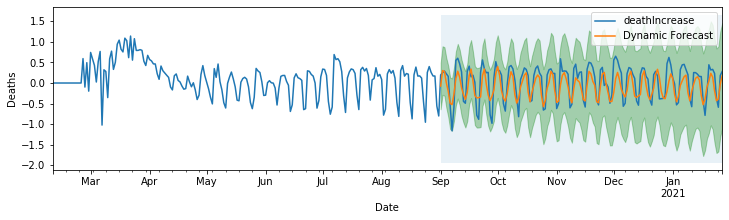

In [56]:
# Plot the dynamic forecast with confidence intervals.

ax = deaths_data_minus_roll_mean['2020-02-10':].plot(label='observed', figsize=(12, 3))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-09-01'), deaths_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Deaths')

plt.legend()
plt.show()

In [57]:
# Extract the predicted and true values of our time series
deaths_forecasted = pred_dynamic.predicted_mean
deaths_truth = deaths_data_minus_roll_mean['2020-09-01':]

# Compute the mean square error
mse = ((deaths_forecasted - deaths_truth.deathIncrease) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.09


In [58]:
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

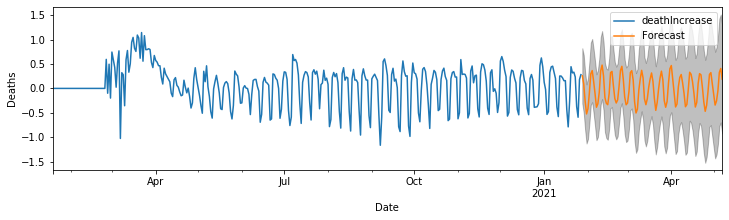

In [59]:
# Plot future predictions with confidence intervals
ax = deaths_data_minus_roll_mean.plot(label='observed', figsize=(12, 3))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Deaths')

plt.legend()
plt.show()

#### Positive Cases Model

In [60]:
"""UNCOMMENT THIS CELL TO RUN GRID SEARCH"""
# # Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
# ans = []
# for comb in pdq:
#     for combs in pdqs:
#         try:
#             mod = SARIMAX(pos_data_minus_roll_mean,
#                             order=comb,
#                             seasonal_order=combs,
#                             enforce_stationarity=False,
#                             enforce_invertibility=False)

#             output = mod.fit()
#             ans.append([comb, combs, output.aic])
#             print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
#         except:
#             continue

# # Find the parameters with minimal AIC value
# ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])

# # pickle grid parameters
# pickle_out = open("pos_grid.pickle","wb")
# pickle.dump(ans_df, pickle_out)
# pickle_out.close()

'UNCOMMENT THIS CELL TO RUN GRID SEARCH'

In [61]:
# load grid parameters
ans_df = pd.read_pickle('pos_grid.pickle')
ans_df

,pdq,pdqs,aic
0,"(0, 0, 0)","(0, 0, 0, 12)",254.241720
1,"(0, 0, 0)","(0, 0, 1, 12)",204.127775
2,"(0, 0, 0)","(0, 0, 2, 12)",200.938750
3,"(0, 0, 0)","(0, 1, 0, 12)",327.629202
4,"(0, 0, 0)","(0, 1, 1, 12)",248.095460
...,...,...,...
319,"(2, 1, 2)","(2, 0, 1, 12)",-225.005022
320,"(2, 1, 2)","(2, 0, 2, 12)",-237.850402
321,"(2, 1, 2)","(2, 1, 0, 12)",-114.192873
322,"(2, 1, 2)","(2, 1, 1, 12)",-159.740921


In [62]:
ARIMA_MODEL = SARIMAX(pos_data_minus_roll_mean,
                      order=ans_df.loc[ans_df['aic'].idxmin()][0],
                      seasonal_order=ans_df.loc[ans_df['aic'].idxmin()][1], 
                      enforce_stationarity=False,
                      enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8436      0.012     68.339      0.000       0.819       0.868
ar.S.L12       0.0270      0.086      0.315      0.753      -0.141       0.195
ar.S.L24       0.5195      0.039     13.193      0.000       0.442       0.597
ma.S.L12      -0.2949      0.070     -4.242      0.000      -0.431      -0.159
ma.S.L24      -0.9857      0.104     -9.444      0.000      -1.190      -0.781
sigma2         0.0189      0.002      8.579      0.000       0.015       0.023


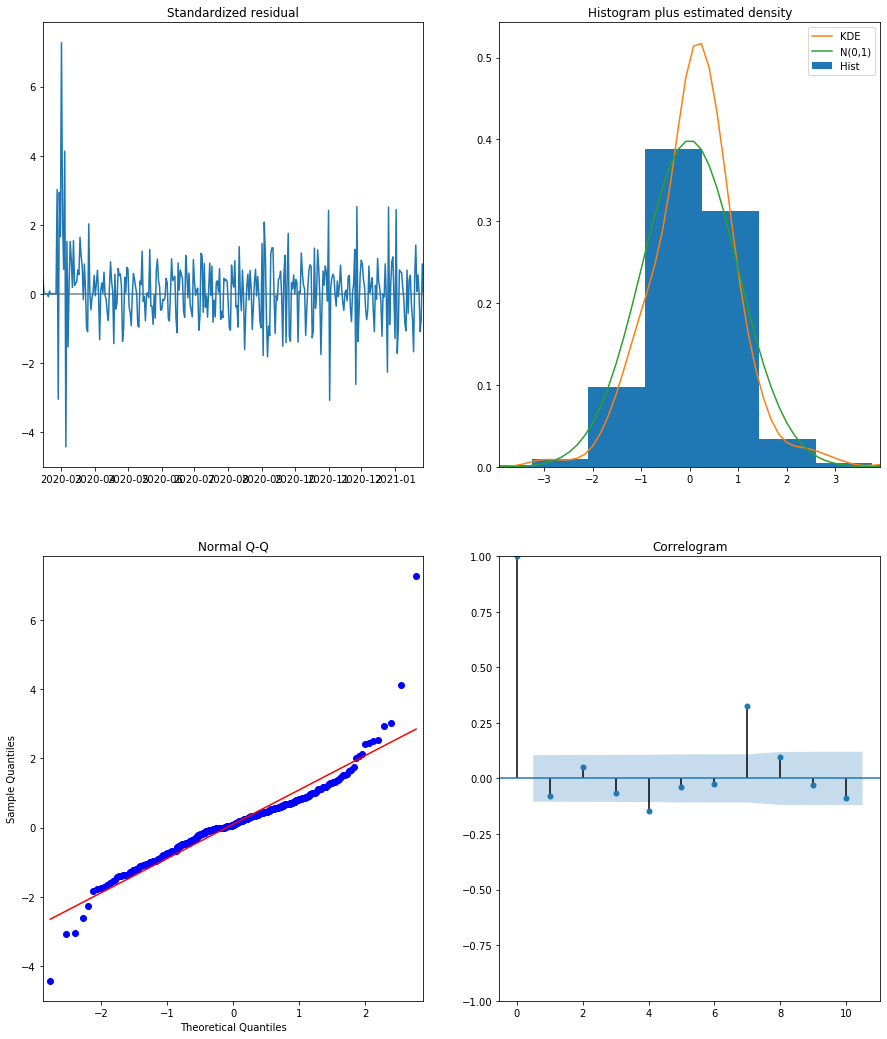

In [63]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [64]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2020-09-01'), dynamic=False)
pred_conf = pred.conf_int()

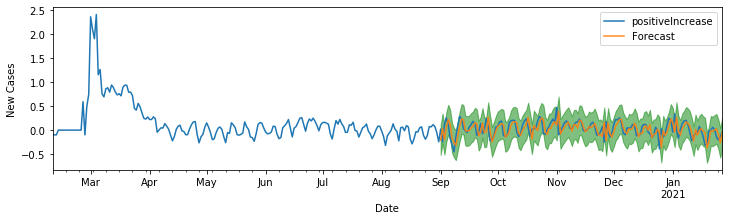

In [65]:
# Plot real vs predicted values along with confidence interval
plt.rcParams['figure.figsize'] = 12, 3

# Plot observed values
ax = pos_data_minus_roll_mean['2020-02-10':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('New Cases')
plt.legend()

plt.show()

In [66]:
# Get the real and predicted values
pos_forecasted = pred.predicted_mean
pos_truth = pos_data_minus_roll_mean['2020-09-01':]

# Compute the mean square error
mse = ((pos_forecasted - pos_truth.positiveIncrease) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.02


In [67]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2020-09-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

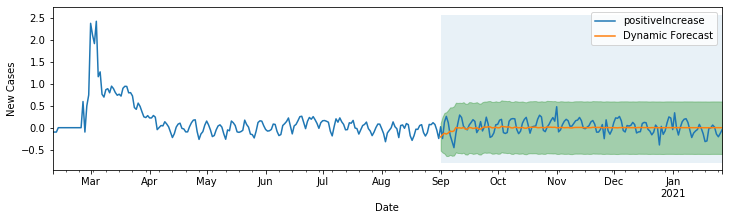

In [68]:
# Plot the dynamic forecast with confidence intervals.

ax = pos_data_minus_roll_mean['2020-02-10':].plot(label='observed', figsize=(12, 3))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-09-01'), pos_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('New Cases')

plt.legend()
plt.show()

In [69]:
# Extract the predicted and true values of our time series
pos_forecasted = pred_dynamic.predicted_mean
pos_truth = pos_data_minus_roll_mean['2020-09-01':]

# Compute the mean square error
mse = ((pos_forecasted - pos_truth.positiveIncrease) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.02


In [70]:
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

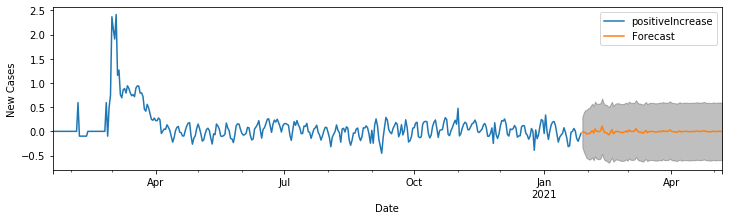

In [71]:
# Plot future predictions with confidence intervals
ax = pos_data_minus_roll_mean.plot(label='observed', figsize=(12, 3))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('New Cases')

plt.legend()
plt.show()

## Prophet

In [72]:
from fbprophet import Prophet

In [73]:
ts.index.name = 'ds'
ts = ts.reset_index()
ts = ts.rename(columns={'timeline': 'y'})

In [74]:
Model = Prophet(interval_width=0.95)
Model.fit(ts)

/Users/elliotmacy/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [75]:
future_dates = Model.make_future_dataframe(periods=30, freq='D')
future_dates.tail()

,ds
397,2021-02-22
398,2021-02-23
399,2021-02-24
400,2021-02-25
401,2021-02-26


In [76]:
forecast = Model.predict(future_dates)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,3.823959,-323.086436,325.518545,3.823959,3.823959,-4.917073,-4.917073,-4.917073,-4.917073,-4.917073,-4.917073,0.0,0.0,0.0,-1.093114
1,2020-01-23,3.468861,-328.767919,341.553551,3.468861,3.468861,5.698221,5.698221,5.698221,5.698221,5.698221,5.698221,0.0,0.0,0.0,9.167082
2,2020-01-24,3.113763,-320.231877,343.496180,3.113763,3.113763,5.905562,5.905562,5.905562,5.905562,5.905562,5.905562,0.0,0.0,0.0,9.019325
3,2020-01-25,2.758666,-296.659781,315.743494,2.758666,2.758666,2.957125,2.957125,2.957125,2.957125,2.957125,2.957125,0.0,0.0,0.0,5.715790
4,2020-01-26,2.403568,-320.140858,317.405523,2.403568,2.403568,-1.142902,-1.142902,-1.142902,-1.142902,-1.142902,-1.142902,0.0,0.0,0.0,1.260666


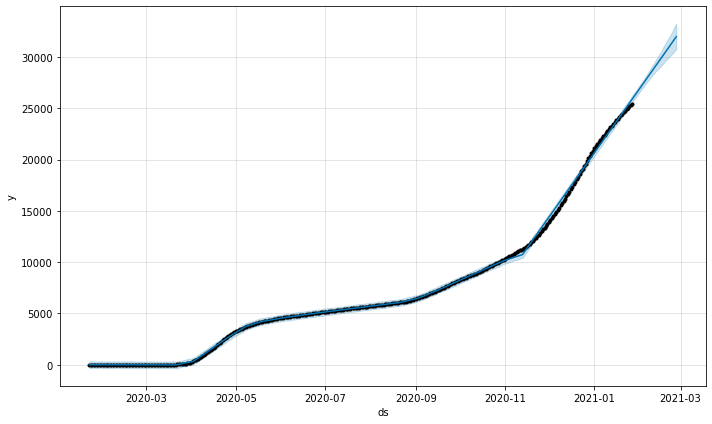

In [77]:
Model.plot(forecast, uncertainty=True)
plt.show()

## LSTM

In [78]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [79]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [80]:
df = pd.DataFrame()
df['death'] = ts['y']

In [81]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df)

In [82]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
train.shape, test.shape

((249, 1), (123, 1))

In [83]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [84]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [85]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=-1)

In [86]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = mean_squared_error(trainY[0], trainPredict[:,0], squared=False)
print('Train Score: %.2f RMSE' % (trainScore))
testScore = mean_squared_error(testY[0], testPredict[:,0], squared=False)
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2300.18 RMSE
Test Score: 10827.11 RMSE


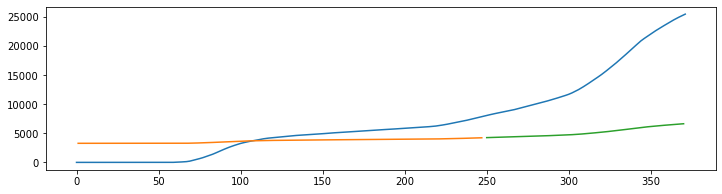

In [87]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Conclusion